In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
import os

# Print current working directory
print(f"Current working directory: {os.getcwd()}")

# List all files in the data directory
try:
    print("\nFiles in 'data' directory:")
    for file in os.listdir('data'):
        print(f"  - {file}")
except Exception as e:
    print(f"Error listing 'data' directory: {e}")

# Try one directory up
try:
    parent_dir = os.path.dirname(os.getcwd())
    print(f"\nParent directory: {parent_dir}")
    print("\nFiles in parent/data directory:")
    parent_data_dir = os.path.join(parent_dir, 'data')
    if os.path.exists(parent_data_dir):
        for file in os.listdir(parent_data_dir):
            print(f"  - {file}")
    else:
        print(f"Directory doesn't exist: {parent_data_dir}")
except Exception as e:
    print(f"Error listing parent/data directory: {e}")

# List all files in current directory
try:
    print("\nFiles in current directory:")
    for file in os.listdir('.'):
        print(f"  - {file}")
except Exception as e:
    print(f"Error listing current directory: {e}")

Current working directory: c:\Users\rachi\Documents\GitHub\STA141C\notebooks

Files in 'data' directory:
Error listing 'data' directory: [WinError 3] The system cannot find the path specified: 'data'

Parent directory: c:\Users\rachi\Documents\GitHub\STA141C

Files in parent/data directory:
  - ckd-dataset-v2.csv

Files in current directory:
  - EDA.ipynb


In [7]:
df = pd.read_csv(r"C:\Users\rachi\Documents\GitHub\STA141C\data\ckd-dataset-v2.csv")

In [9]:
# Remove metadata rows (rows with 'discrete' in class column)
df = df[df['class'].isin(['ckd', 'notckd'])]

# Convert target to binary (1 for ckd, 0 for notckd)
df['target'] = (df['class'] == 'ckd').astype(int)

# Reset index
df.reset_index(drop=True, inplace=True)

# Display basic info
print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['class'].value_counts())
print("\nTarget distribution:")
print(df['target'].value_counts())

Dataset shape: (200, 30)

Class distribution:
class
ckd       128
notckd     72
Name: count, dtype: int64

Target distribution:
target
1    128
0     72
Name: count, dtype: int64


In [10]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
print("\nMissing values:")
print(missing_data[missing_data['Missing Values'] > 0])

# Preview data types
print("\nData types:")
print(df.dtypes)

# Preview first few rows
print("\nFirst 5 rows:")
print(df.head())


Missing values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Data types:
bp (Diastolic)    object
bp limit          object
sg                object
al                object
class             object
rbc               object
su                object
pc                object
pcc               object
ba                object
bgr               object
bu                object
sod               object
sc                object
pot               object
hemo              object
pcv               object
rbcc              object
wbcc              object
htn               object
dm                object
cad               object
appet             object
pe                object
ane               object
grf               object
stage             object
affected          object
age               object
target             int64
dtype: object

First 5 rows:
  bp (Diastolic) bp limit             sg     al class rbc   su pc pcc ba  ...  \
0              0        0  1.019 - 1.021  1 - 

In [12]:
# Define a function to process range values
def process_range(value):
    if pd.isna(value):
        return np.nan
    
    value = str(value)
    
    # Handle ranges (e.g., "1.019 - 1.021")
    if ' - ' in value:
        min_val, max_val = value.split(' - ')
        return (float(min_val) + float(max_val)) / 2
    
    # Handle less than (e.g., "< 112")
    if value.startswith('< '):
        return float(value[2:]) * 0.9  # 90% of threshold
    
    # Handle greater than or equal (e.g., "≥ 227.944")
    if value.startswith('≥ '):
        return float(value[2:]) * 1.1  # 110% of threshold
    
    # Handle stage values
    if value == 's1': return 1
    if value == 's2': return 2
    if value == 's3': return 3
    if value == 's4': return 4
    if value == 's5': return 5
    
    # Convert binary values
    if value == '0': return 0
    if value == '1': return 1
    
    # Try to convert to float
    try:
        return float(value)
    except:
        return value

# Create a processed dataframe
df_processed = df.copy()

# Apply the processing function to all columns except 'class' and 'target'
for col in df_processed.columns:
    if col not in ['class', 'target']:
        df_processed[col] = df_processed[col].apply(process_range)

# Check the processed data types
print("Processed data types:")
print(df_processed.dtypes)

# Preview processed data
print("\nFirst 5 rows of processed data:")
print(df_processed.head())

Processed data types:
bp (Diastolic)      int64
bp limit          float64
sg                float64
al                float64
class              object
rbc                 int64
su                float64
pc                  int64
pcc                 int64
ba                  int64
bgr               float64
bu                float64
sod               float64
sc                float64
pot               float64
hemo              float64
pcv               float64
rbcc              float64
wbcc              float64
htn                 int64
dm                  int64
cad                 int64
appet               int64
pe                  int64
ane                 int64
grf                object
stage               int64
affected            int64
age               float64
target              int64
dtype: object

First 5 rows of processed data:
   bp (Diastolic)  bp limit     sg   al class  rbc   su  pc  pcc  ba  ...  dm  \
0               0       0.0  1.020  1.0   ckd    0  0.0   0    0   0  

Numeric columns: 28


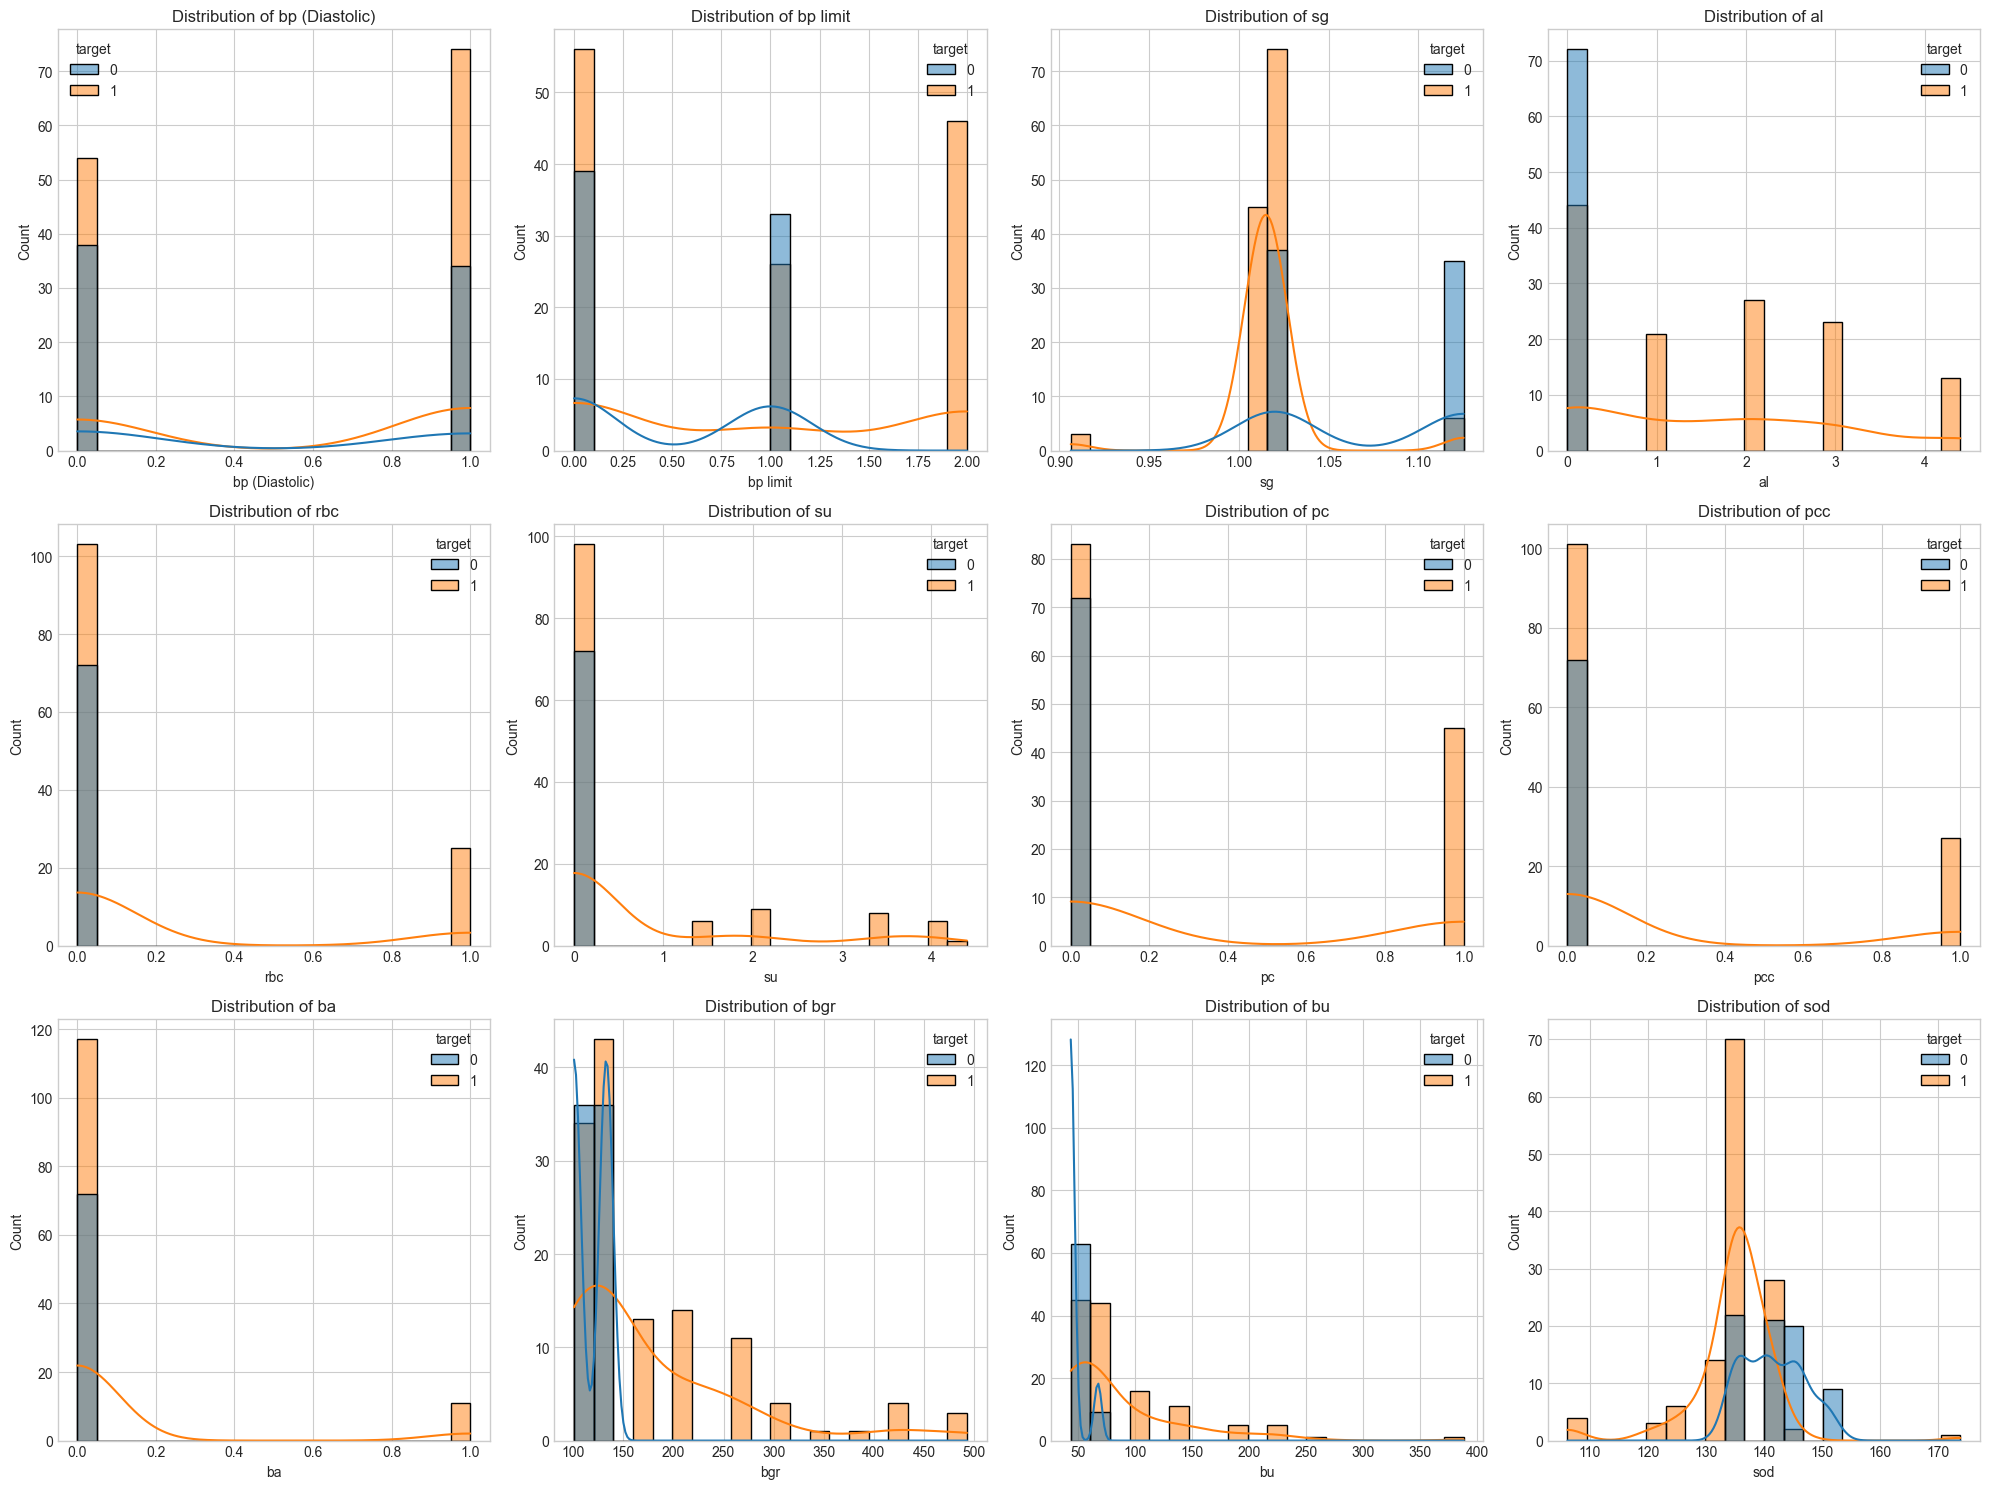

In [13]:
# Identify numeric columns after processing
numeric_cols = df_processed.select_dtypes(include=['number']).columns.tolist()
print(f"Numeric columns: {len(numeric_cols)}")

# Plot histograms for numeric features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols[:12], 1):  # Plot first 12 numeric features
    plt.subplot(3, 4, i)
    sns.histplot(data=df_processed, x=col, hue='target', kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Binary features show clear separation between CKD and non-CKD groups:

pc (pus cell) and pcc (pus cell clumps) show strong presence in CKD patients
rbc (red blood cells in urine) shows similar pattern


Continuous features show important distributions:

bgr (blood glucose) shows higher values in CKD patients with multiple peaks, suggesting diabetes comorbidity
bu (blood urea) shows very clear separation, with CKD patients having much higher values
sod (sodium) shows interesting distribution patterns in both groups


Special pattern features:

sg (specific gravity) shows concentration around specific values
al (albumin) shows higher values in CKD patients, fitting with proteinuria being a key indicator

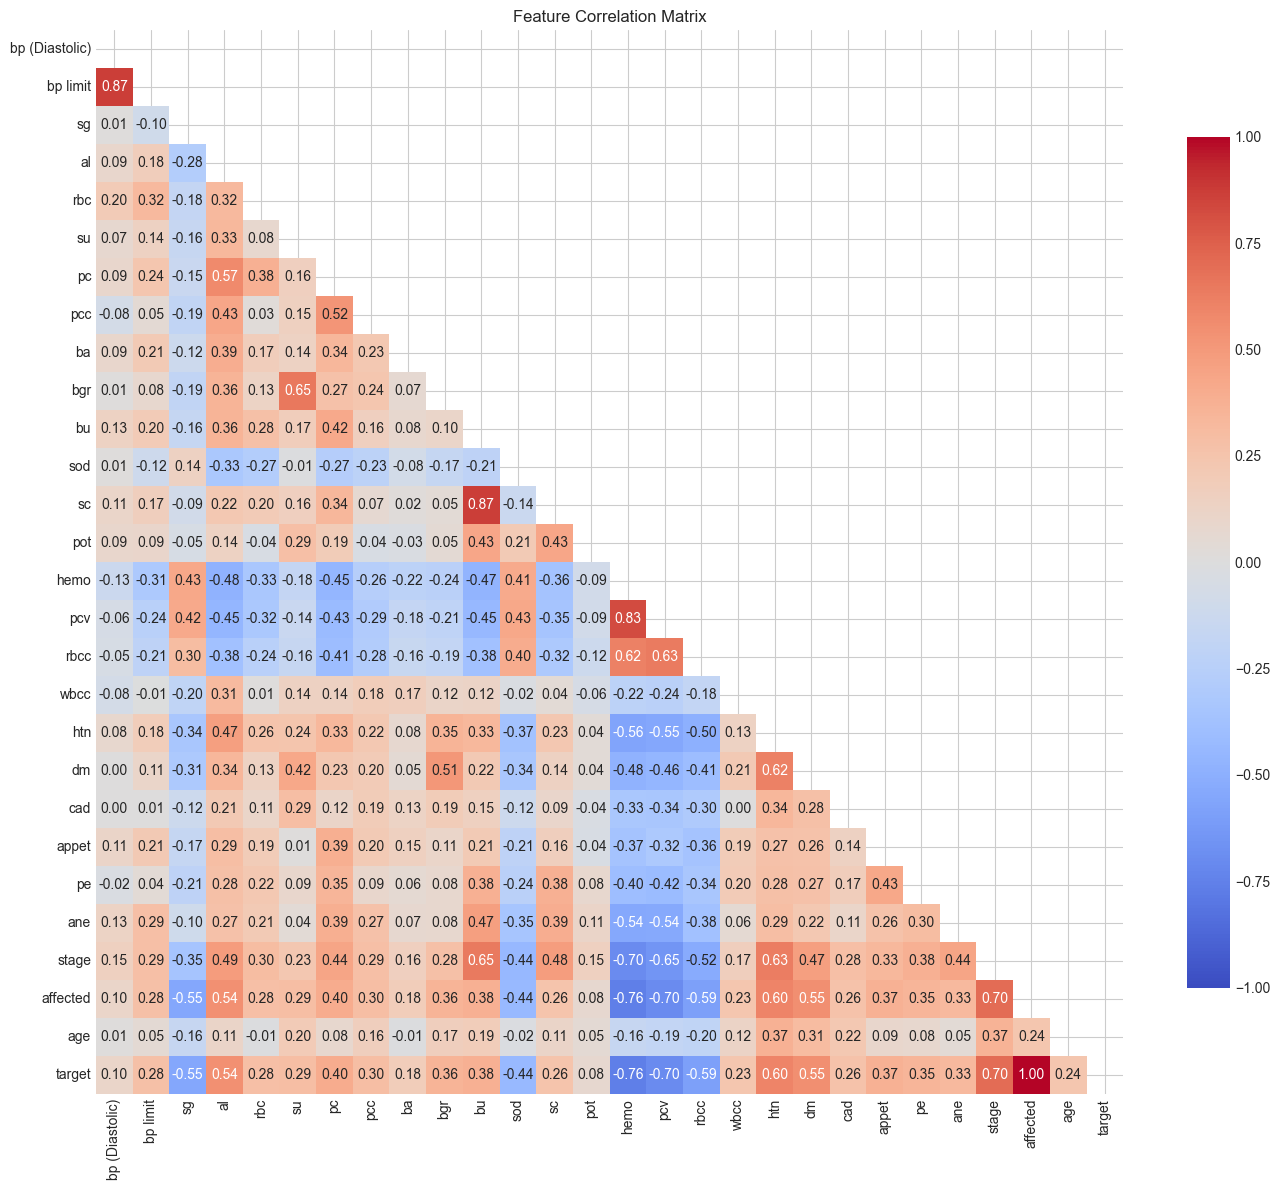

Correlation with target:
target            1.000000
affected          1.000000
stage             0.701045
htn               0.599693
dm                0.550350
al                0.543613
pc                0.404112
bu                0.379671
appet             0.375000
bgr               0.356379
pe                0.345425
ane               0.327327
pcc               0.296292
su                0.292864
rbc               0.283473
bp limit          0.277050
cad               0.263671
sc                0.255042
age               0.238695
wbcc              0.234732
ba                0.180937
bp (Diastolic)    0.101994
pot               0.077975
sod              -0.435611
sg               -0.547291
rbcc             -0.589654
pcv              -0.701990
hemo             -0.762132
Name: target, dtype: float64


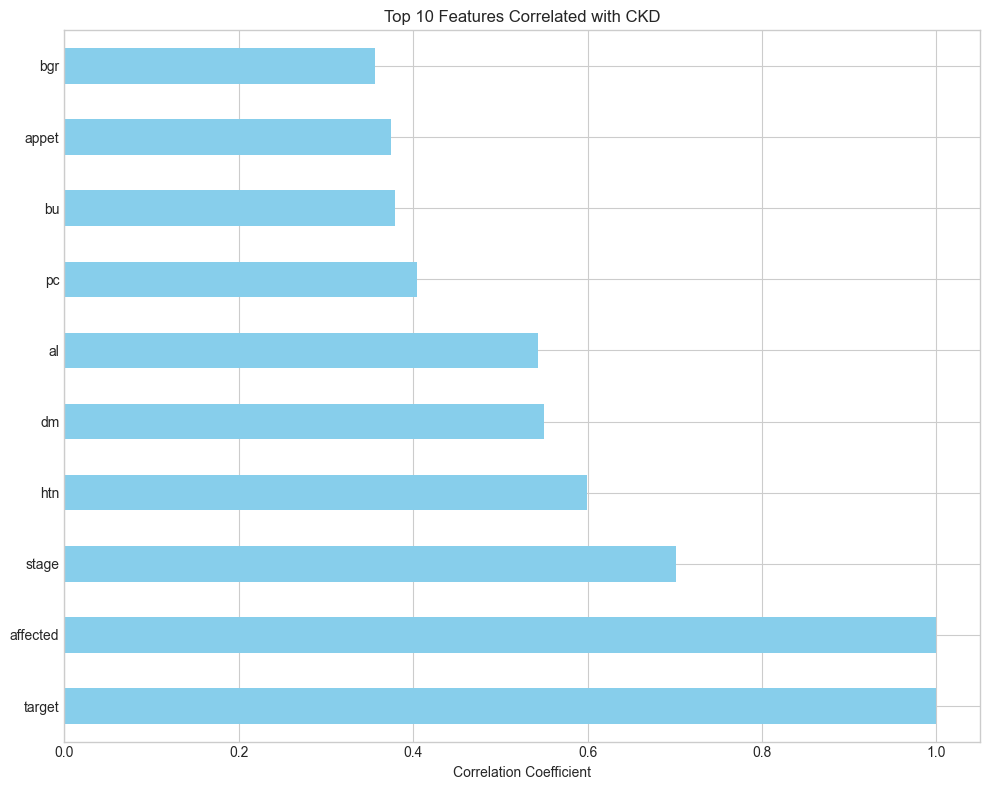

In [14]:
# Calculate correlation matrix
corr_matrix = df_processed[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Calculate correlation with target
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Correlation with target:")
print(target_corr)

# Plot top correlations with target
plt.figure(figsize=(10, 8))
target_corr = target_corr[:-1]  # Remove self-correlation
top_correlations = target_corr.head(10)
top_correlations.plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Correlated with CKD')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


### Key Findings from Target Correlations:

1. **Perfect Positive Correlation (1.0)**:
   - `affected` has a perfect correlation of 1.0 with the target, which essentially means it's providing the same information as the target. This is likely a data leakage issue or another way of encoding the CKD diagnosis. You should exclude this feature from your models to avoid overfitting and ensure your model is learning from actual predictors rather than another encoding of the outcome.

2. **Strong Positive Correlations (0.5-0.7)**:
   - `stage` (0.70): The stage of kidney disease is strongly correlated with CKD diagnosis
   - `htn` (0.60): Hypertension is a major risk factor
   - `dm` (0.55): Diabetes mellitus is another key risk factor
   - `al` (0.54): Albumin in urine (proteinuria) is a clinical indicator of kidney damage

3. **Moderate Positive Correlations (0.3-0.5)**:
   - `pc` (0.40): Pus cells in urine
   - `bu` (0.38): Blood urea level
   - `appet` (0.38): Appetite changes
   - `bgr` (0.36): Blood glucose
   - `pe` (0.35): Peripheral edema
   - `ane` (0.33): Anemia

4. **Weak Positive Correlations (0.1-0.3)**:
   - Several features including `pcc`, `su`, `rbc`, `bp limit`, `cad`, `sc`, etc.

5. **Negligible Correlations (0-0.1)**:
   - `bp (Diastolic)` (0.10)
   - `pot` (0.08): Potassium level

6. **Negative Correlations**:
   - `sod` (-0.44): Sodium level
   - `rbcc` (-0.59): Red blood cell count
   - `pcv` (-0.70): Packed cell volume
   - `hemo` (-0.76): Hemoglobin

### Implications for Your Model Development:

1. **Feature Removal**:
   - Definitely remove `affected` from your models since it has a perfect correlation with the target (data leakage)

2. **Clinical Significance**:
   - The strong negative correlations of `hemo`, `pcv`, and `rbcc` align with medical knowledge - anemia (low hemoglobin/red blood cells) is a common complication of CKD
   - The strong positive correlations with `htn` and `dm` confirm these as key risk factors
   - Lower sodium (`sod`) is associated with CKD, which aligns with electrolyte imbalances common in kidney disease

3. **Feature Groupings**:
   - Consider these natural groupings in your analysis:
     - Anemia markers: `hemo`, `pcv`, `rbcc` (all negatively correlated)
     - Comorbidity indicators: `htn`, `dm`, `cad`
     - Urine abnormality indicators: `al`, `pc`, `pcc`, `rbc`
     - Electrolyte/metabolic indicators: `sod`, `pot`, `bu`, `sc`, `bgr`
     - Symptom indicators: `appet`, `pe`, `ane`

4. **For Logistic Regression with Lasso**:
   - The Lasso regularization will help select the most important features from groups of correlated features
   - Pay attention to which features the Lasso model retains from correlated groups

5. **For Tree-based Models** (Random Forest and Gradient Boosting):
   - These models will naturally handle the non-linear relationships between features
   - They will also capture interaction effects between variables like `htn` and `dm` or between lab values

6. **Prediction Interpretability**:
   - With these correlation patterns, your model should align well with clinical understanding
   - Focus on which lab values and clinical factors most strongly influence predictions



Strongest predictors of CKD:

affected has a perfect or near-perfect correlation (1.0) with the target, which suggests it might be a direct indicator of kidney disease status
stage has a strong correlation (~0.7), which makes clinical sense as the stage of kidney disease is directly related to CKD diagnosis
htn (hypertension) shows significant correlation (~0.6), aligning with medical knowledge that hypertension is a key risk factor for CKD
dm (diabetes mellitus) also shows strong correlation (~0.55), another well-known risk factor for CKD


Moderate predictors:

al (albumin) shows moderate correlation (~0.5), which makes sense as protein in urine is a key diagnostic indicator
pc (pus cell), bu (blood urea), appet (appetite), and bgr (blood glucose) all show moderate correlations (~0.4), indicating their clinical relevance

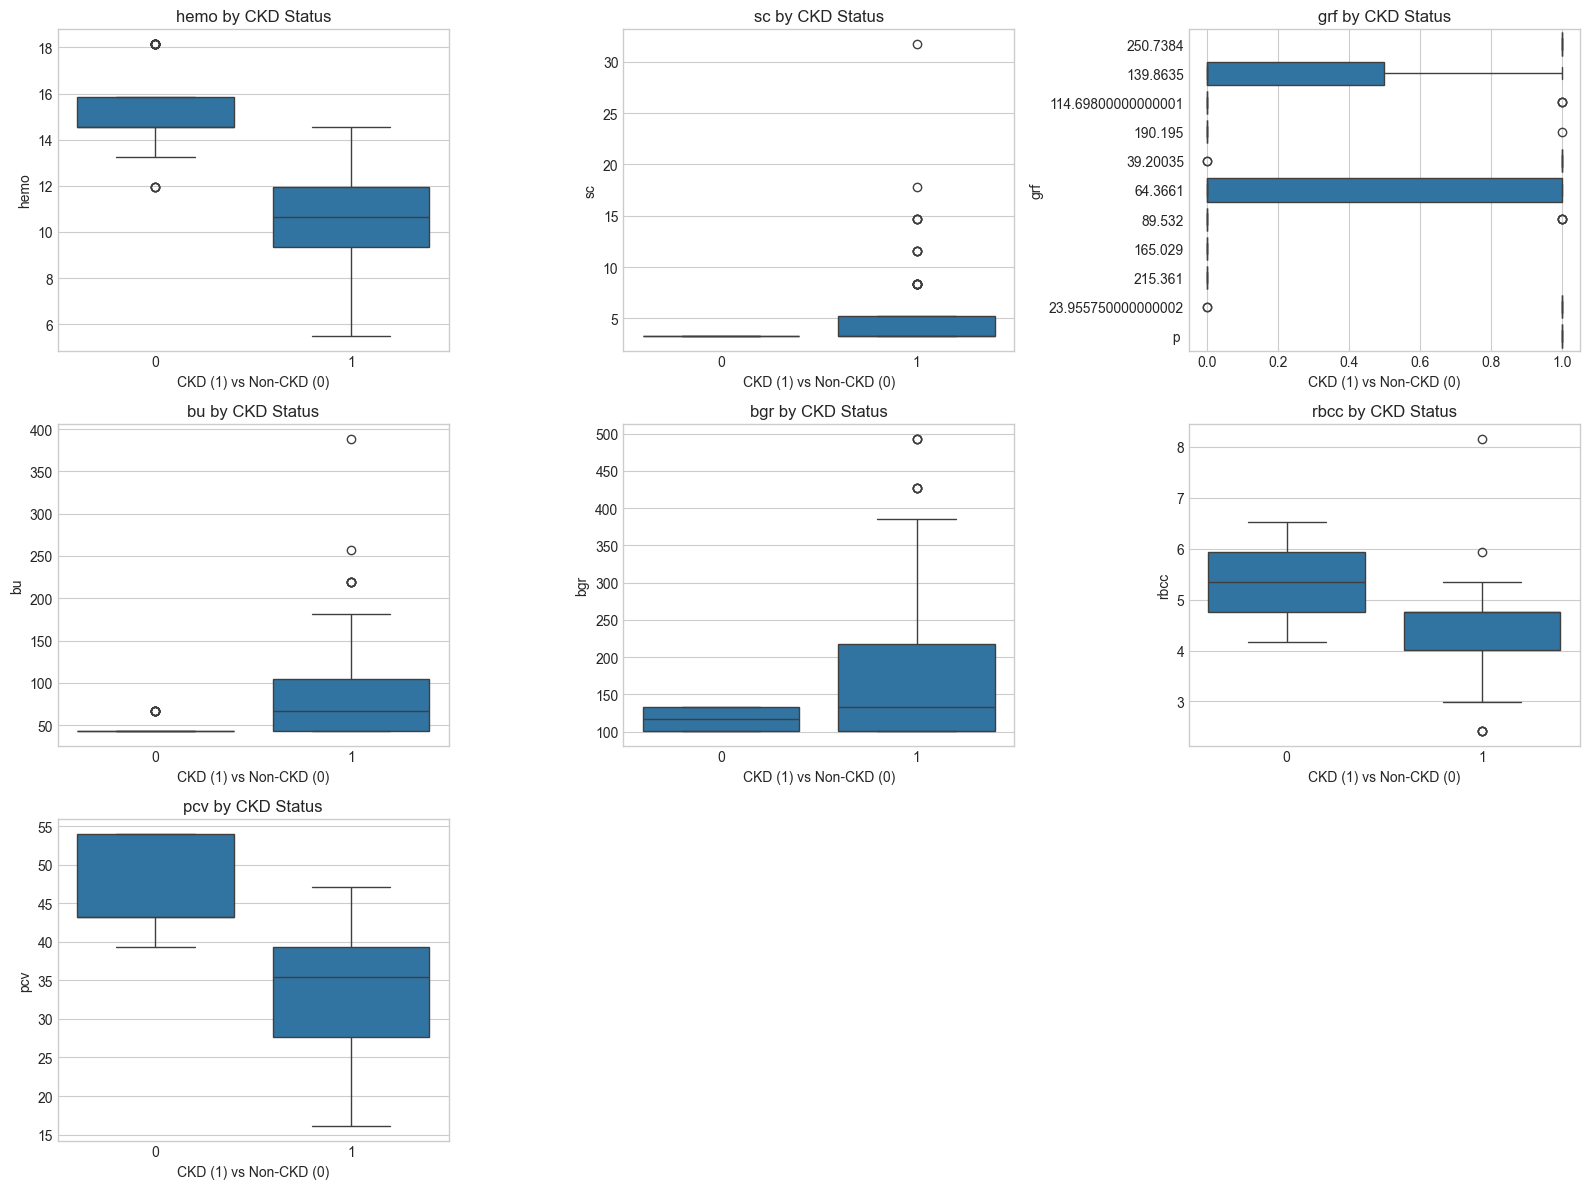

In [15]:
# Create boxplots for key features by CKD status
important_features = ['hemo', 'sc', 'grf', 'bu', 'bgr', 'rbcc', 'pcv']  # Select features that might be important

plt.figure(figsize=(16, 12))
for i, feature in enumerate(important_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='target', y=feature, data=df_processed)
    plt.title(f'{feature} by CKD Status')
    plt.xlabel('CKD (1) vs Non-CKD (0)')
plt.tight_layout()
plt.show()